In [3]:
import pandas as pd

DATA_PATH = r"C:\Users\mohds\Downloads\titanic\train.csv"  

df = pd.read_csv(DATA_PATH)
print(df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

Loaded data shape: (891, 12)
Train/test shapes: (712, 11) (179, 11)
Accuracy (train): 0.8398876404494382
Accuracy (test) : 0.8379888268156425

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       110
           1       0.82      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



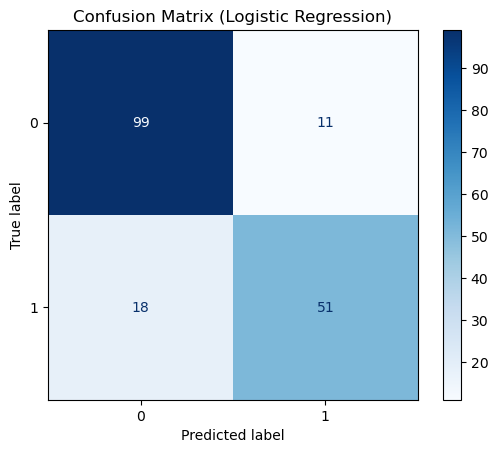

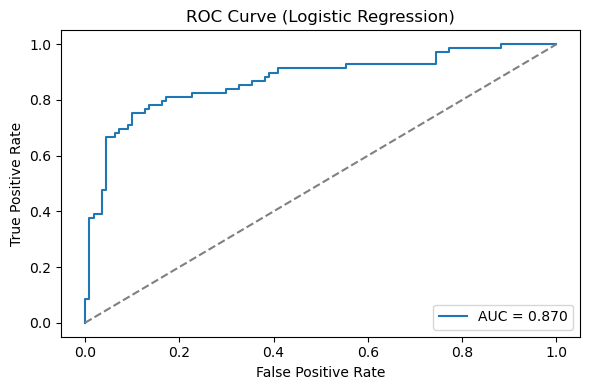

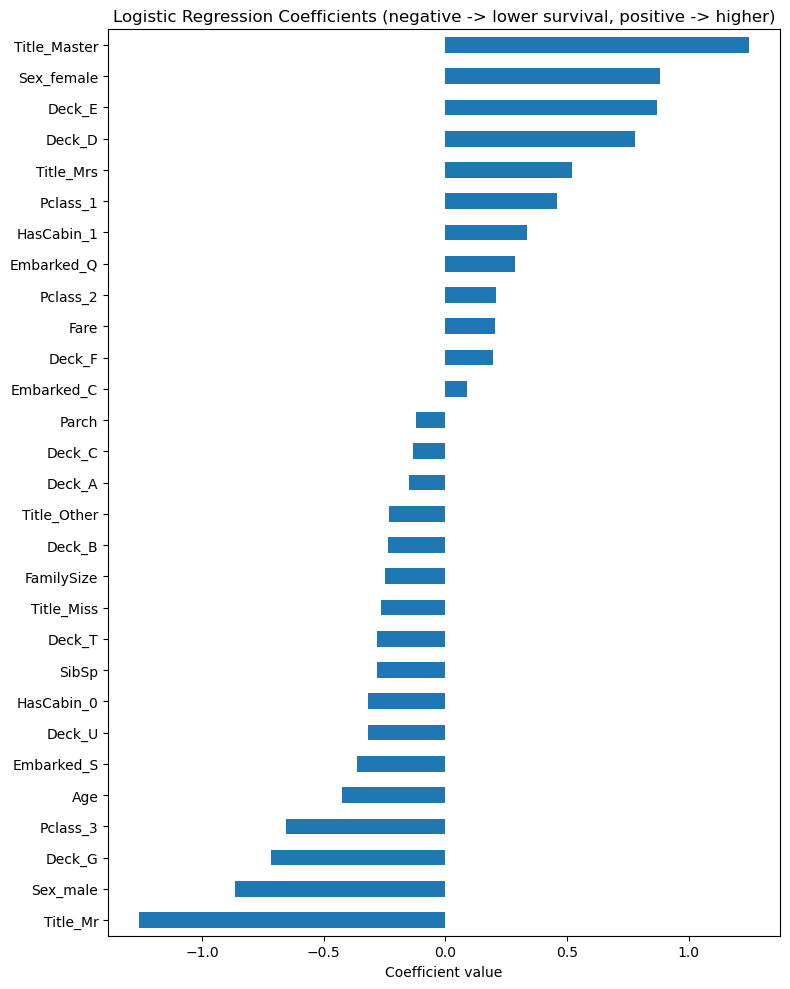


Top positive features (increase odds of survival):
Fare            0.206222
Pclass_2        0.208669
Embarked_Q      0.287006
HasCabin_1      0.334051
Pclass_1        0.461190
Title_Mrs       0.520140
Deck_D          0.779961
Deck_E          0.869640
Sex_female      0.880900
Title_Master    1.250170
dtype: float64

Top negative features (decrease odds of survival):
Title_Mr     -1.260012
Sex_male     -0.864968
Deck_G       -0.715177
Pclass_3     -0.653926
Age          -0.424994
Embarked_S   -0.361398
Deck_U       -0.318119
HasCabin_0   -0.318119
SibSp        -0.279667
Deck_T       -0.279062
dtype: float64


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, ConfusionMatrixDisplay
)

DATA_PATH = r"C:\Users\mohds\Downloads\titanic\train.csv"  

df = pd.read_csv(DATA_PATH)
print("Loaded data shape:", df.shape)

df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
df['Title'] = df['Title'].apply(lambda t: t if t in common_titles else 'Other')

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['Deck'] = df['Cabin'].fillna('U').astype(str).str[0]
df['HasCabin'] = df['Cabin'].notnull().astype(int)

df_model = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

X = df_model.drop(columns=['Survived'])
y = df_model['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/test shapes:", X_train.shape, X_test.shape)

num_cols = ['Age', 'Fare', 'FamilySize', 'SibSp', 'Parch']
cat_cols = ['Sex', 'Embarked', 'Pclass', 'Title', 'Deck', 'HasCabin']


num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_num = num_imputer.fit_transform(X_train[num_cols])
X_train_num = scaler.fit_transform(X_train_num)

cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat_imp = cat_imputer.fit_transform(X_train[cat_cols])

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train_cat_imp)

X_train_prepared = np.hstack([X_train_num, X_train_cat])

X_test_num = num_imputer.transform(X_test[num_cols])
X_test_num = scaler.transform(X_test_num)

X_test_cat_imp = cat_imputer.transform(X_test[cat_cols])
X_test_cat = ohe.transform(X_test_cat_imp)

X_test_prepared = np.hstack([X_test_num, X_test_cat])


clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_prepared, y_train)


y_pred = clf.predict(X_test_prepared)
y_proba = clf.predict_proba(X_test_prepared)[:,1]

print("Accuracy (train):", clf.score(X_train_prepared, y_train))
print("Accuracy (test) :", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


ohe_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(ohe_feature_names)

coefs = clf.coef_.ravel()
coef_series = pd.Series(coefs, index=feature_names).sort_values()

plt.figure(figsize=(8,10))
coef_series.plot(kind='barh')
plt.title("Logistic Regression Coefficients (negative -> lower survival, positive -> higher)")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()

print("\nTop positive features (increase odds of survival):")
print(coef_series.tail(10))
print("\nTop negative features (decrease odds of survival):")
print(coef_series.head(10))
